In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter, savgol_coeffs

import math

import json

# General Tool Functions

In [2]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)

In [3]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor < 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5, polyorder=3):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = polyorder
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

In [4]:
def calculate_slope_integral(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_slope_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=1
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=1, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_prime = D @ I
    I_prime_sq = I_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def calculate_curvature_integral(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I
    
    # Use Savitzky-Golay filter to get the second derivative of intensity with respect to Q
    smoothed_I_double_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=2, delta=np.mean(np.diff(Q_best)))
    
    # Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_curvature_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=2
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=2, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_double_prime = D @ I
    I_double_prime_sq = I_double_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_double_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_double_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def f_beta(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the beta parameter 
    """
    beta = calculate_slope_integral(data, window_length, polyorder) / (12.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_slope_integral_with_uncertainty(data, window_length, polyorder)
        beta, beta_std = integral / (12.0 * (data.Q.max() - data.Q.min())), integral_std / (12.0 * (data.Q.max() - data.Q.min()))
        return beta, beta_std
    return beta

def f_gamma(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the gamma parameter 
    """
    gamma = calculate_curvature_integral(data, window_length, polyorder) / (4.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_curvature_integral_with_uncertainty(data, window_length, polyorder)
        gamma, gamma_std = integral / (4.0 * (data.Q.max() - data.Q.min())), integral_std / (4.0 * (data.Q.max() - data.Q.min()))
        return gamma, gamma_std
    return gamma

def f_alpha(data, total_counts):
    """
    Calculate the A0 parameter 
    """
    L = data.Q.max() - data.Q.min()
    mean_I = np.mean(data.I)
    return L * (mean_I ** 2)/ total_counts

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

['../data/hanaro_Apr1/APR01031.ABS', '../data/hanaro_Apr1/APR01032.ABS', '../data/hanaro_Apr1/APR01033.ABS', '../data/hanaro_Apr1/APR01034.ABS', '../data/hanaro_Apr1/APR01035.ABS', '../data/hanaro_Apr1/APR01036.ABS', '../data/hanaro_Apr1/APR01037.ABS', '../data/hanaro_Apr1/APR01038.ABS']
173
173
173
173
173
173
173
173
count per sec: 16.67031758106049
average bin size: 0.00021469364161849711


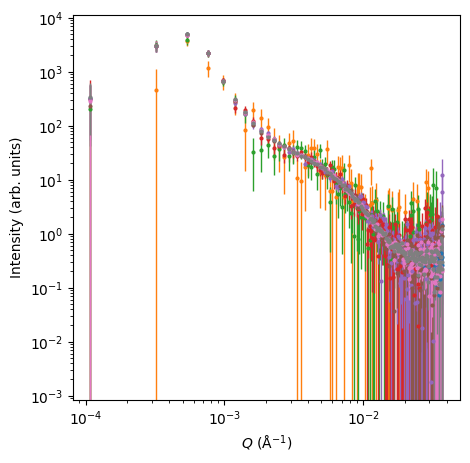

In [5]:
file_path = '../data/hanaro_Apr1/'
filenames = [f"APR{str(i).zfill(5)}.ABS" for i in range(1031, 1039)]
files = [os.path.join(file_path, fname) for fname in filenames]
print(files)

data_list = []
time_list = []
# Read data from files
for file in files:
    data = np.loadtxt(file, skiprows=14)
    # Extract collection time from filename using regex
    # Example filename: Apr01031.0058321.txt -> collection time is the number after the dot
    # Extract collection time from file by reading the header
    collection_time = None
    with open(file, 'r') as f:
        for _ in range(14):  # Read header lines
            line = f.readline()
            match = re.search(r'LABEL:.*?(\d+)s', line)
            if match:
                collection_time = int(match.group(1))
                break
    data_list.append(data)
    time_list.append(collection_time)
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
# ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))
print('average bin size: {}'.format((np.max(Q) - np.min(Q)) / len(Q)))
delta_Q_ave = (np.max(Q) - np.min(Q)) / len(Q)

## Produce Rebinned Data and Evaluate Performance

Using best dataset: Bin size = EQSANS, Time = 10000
Best data total counts: 10000
Using nbins = 192 for EQSANS synthetic data generation


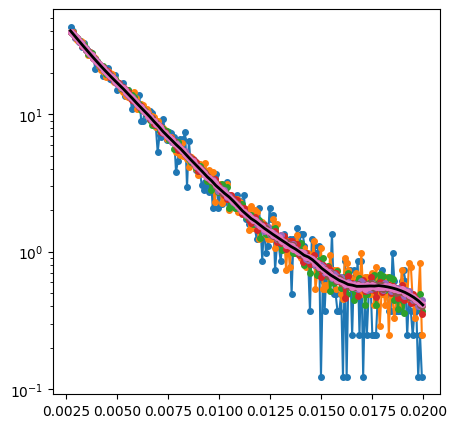

In [6]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 2.5e-3
Q_max_range = 2e-2

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

count_list = [1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7]
count_list = np.array(count_list, dtype=float)
count_list = count_list

# count_list = np.array(time_list)*np.mean(estimated_total_counts)/np.mean(time_list)

N_MC = 16
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = 192
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=21, polyorder=3)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=21, polyorder=3), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
ax.set_yscale('log')
ax.set_xscale('linear')

In [7]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=21, polyorder=3, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=21, polyorder=3, std=True)
A0_best = f_alpha(best_data, total_counts)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=21, polyorder=3)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['EQSANS'][collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)
    


alpha*n = 7.5316e-08
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
h_instr = 8.9526e-05
time = 10000.0, h_FD = 2.9892e-04, lambda_opt = 2.9082e-04
time = 30000.0, h_FD = 2.0726e-04, lambda_opt = 2.3345e-04
time = 100000.0, h_FD = 1.3875e-04, lambda_opt = 1.8349e-04
time = 300000.0, h_FD = 9.6201e-05, lambda_opt = 1.4730e-04
time = 1000000.0, h_FD = 6.4400e-05, lambda_opt = 1.1578e-04
time = 3000000.0, h_FD = 4.4653e-05, lambda_opt = 9.2939e-05
time = 10000000.0, h_FD = 2.9892e-05, lambda_opt = 7.3050e-05


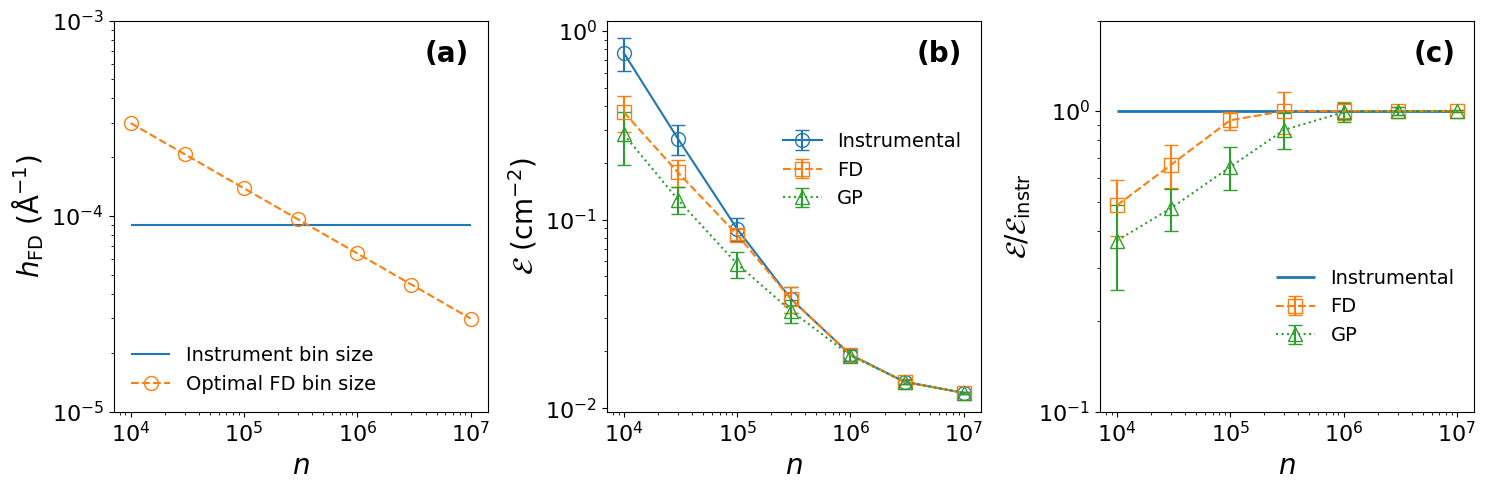

In [26]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument bin size', colors='C0', linestyles='-')
ax.plot(count_list, h_FD_list, 'o--', label='Optimal FD bin size', color='C1', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-3)
ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s--', capsize=5, markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^:', capsize=5, markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='C0', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s--', capsize=5, color='C1', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^:', capsize=5, color='C2', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()